In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import torch as t
from utils.config import opt
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import numpy as np
import pickle

%matplotlib inline

TRAIN_MODE = False

In [2]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

# Load model trained with caffe pretrained model

In [3]:
trainer.load('./checkpoints/fasterrcnn_02272314_0.6720744290992889')
opt.caffe_pretrain=True # this model was trained from caffe-pretrained model

In [4]:
img = read_image('misc/demo.jpg')
img = t.from_numpy(img)[None]

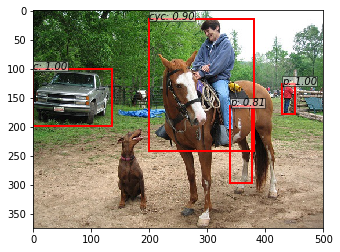

In [5]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

# Display a Kitti image

In [6]:
import os

dataset_dir = '/media/tadenoud/DATADisk/datasets/kitti_2d'  # School comp
# dataset_dir = '/home/tadenoud/Documents/kitti' # Laptop

img_paths = [
    os.path.join(dataset_dir, 'training/image_2/005009.png'),
    os.path.join(dataset_dir, 'training/image_2/005010.png')
]

imgs = np.array([read_image(p) for p in img_paths])

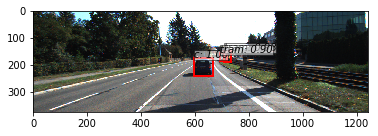

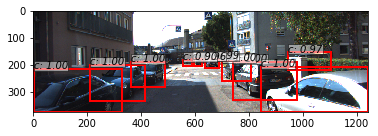

In [7]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(imgs,visualize=True)
vis_bbox(at.tonumpy(imgs[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

vis_bbox(at.tonumpy(imgs[1]),
         at.tonumpy(_bboxes[1]),
         at.tonumpy(_labels[1]).reshape(-1),
         at.tonumpy(_scores[1]).reshape(-1))

In [8]:
# Read a Kitti GT label
from data.util import read_bbox

img_label_paths = [
    os.path.join(dataset_dir, 'training/label_2/005009.txt'),
    os.path.join(dataset_dir, 'training/label_2/005010.txt')
]

gt = np.array([read_bbox(p, ignore_dontcare=True) for p in img_label_paths]) 
gt_bboxes = gt[:,0]
gt_labels = gt[:,1]

scales = np.array([[im.shape[2] / im.shape[1]] for im in imgs])

print(scales)

[[3.312]
 [3.312]]


# Train mahalanobis features with entire training dataset

In [9]:
from utils.config import opt
from data.dataset import Dataset, TestDataset
from torch.utils.data import DataLoader

print('load data')

opt.voc_data_dir = "/media/tadenoud/DATADisk/datasets/kitti_2d/VOC2012/"
dataset = Dataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False,
                        pin_memory=True,
                        num_workers=opt.num_workers)

if TRAIN_MODE:
    mahal_means, mahal_cov = trainer.faster_rcnn.train_ood(dataloader)

    with open('kitti_features.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.features, f)

    with open('mahal_means.pickle', 'wb') as f:
        pickle.dump(mahal_means, f)

    with open('mahal_cov.pickle', 'wb') as f:
        pickle.dump(mahal_cov, f)

    with open('inv_mahal_cov.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.inv_mahal_cov, f)

else:
    with open('kitti_features.pickle', 'rb') as f:
        trainer.faster_rcnn.features = pickle.load(f)

    with open('mahal_means.pickle', 'rb') as f:
        mahal_means = pickle.load(f)
        trainer.faster_rcnn.mahal_means = mahal_means

    with open('mahal_cov.pickle', 'rb') as f:
        mahal_cov = pickle.load(f)
        trainer.faster_rcnn.mahal_cov = mahal_cov

    with open('inv_mahal_cov.pickle', 'rb') as f:
        inv_mahal_cov = pickle.load(f)
        trainer.faster_rcnn.inv_mahal_cov = inv_mahal_cov

load data


In [10]:
from tqdm import tqdm

if TRAIN_MODE:
    with open('gt_labels.pickle', 'wb') as f:
        pickle.dump(trainer.faster_rcnn.gt_labels, f)
# else:
    
with open('gt_labels.pickle', 'rb') as f:
    gt_labels = pickle.load(f)

In [11]:
VOC_BBOX_LABEL_NAMES = (
    'car',
    'van',
    'truck',
    'tram',
    'person',
    'person_sitting',
    'cyclist',
    'misc'
    # 'dontcare
)

for j in range(8):
    print(VOC_BBOX_LABEL_NAMES[j], "count:", sum([i == j for i in gt_labels]))

car count: 2139
van count: 131
truck count: 157
tram count: 22
person count: 361
person_sitting count: 0
cyclist count: 70
misc count: 29


In [12]:
print("Zeros in cov matrix:", (lambda a, b: a * b)(*mahal_cov.shape) - np.count_nonzero(mahal_cov))

Zeros in cov matrix: 0


In [13]:
print("Zeros on cov diag:", (mahal_cov.shape[0] - np.count_nonzero(np.diagonal(mahal_cov))))

Zeros on cov diag: 0


# Visualize features using t-SNE

In [14]:
from time import time
from sklearn.manifold import TSNE

if TRAIN_MODE:
    print("Computing t-SNE embedding")
    tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=20)
    t0 = time()
    X_tsne = tsne.fit_transform(trainer.faster_rcnn.features)
    t1 = time()
    
    with open("tsne_features.pickle", "wb") as f:
        pickle.dump(X_tsne, f)

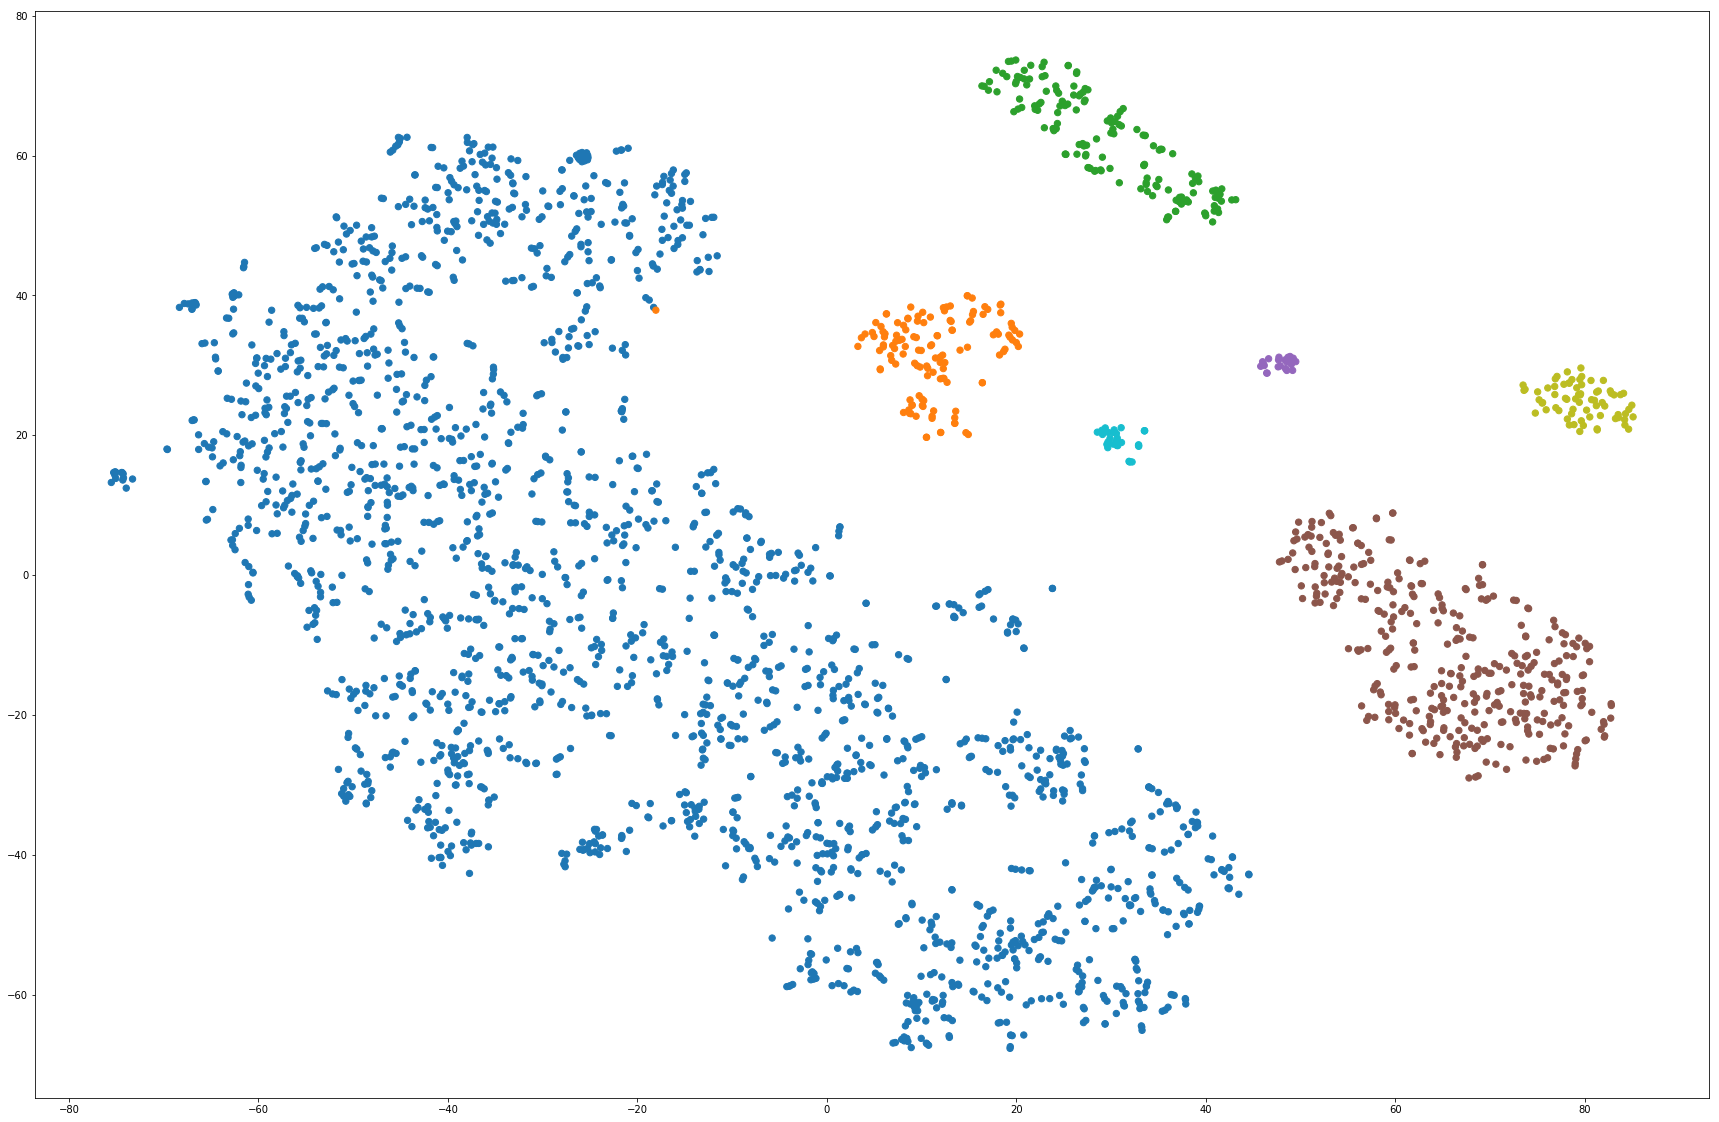

In [15]:
import matplotlib.pyplot as plt

with open("tsne_features.pickle", "rb") as f:
    X_tsne = pickle.load(f)

mask = (gt_labels != -1)
plt.figure(figsize=(30, 20))
plt.scatter(X_tsne[:,0][mask], X_tsne[:,1][mask], c=gt_labels[mask], s=40, cmap=plt.cm.get_cmap('tab10'))
plt.show()

# Predict class using features

In [16]:
# Evaluate baseline softmax method
from train import eval, eval_mahal

print('load data') 
test_dataset = TestDataset(opt)
test_dataloader = DataLoader(test_dataset,
                             batch_size=1,
                             shuffle=False,
                             pin_memory=True,
                             num_workers=opt.num_workers)

if TRAIN_MODE:
    baseline_result = eval(test_dataloader, trainer.faster_rcnn, test_num=3768)
    with open("baseline_results.pickle", 'wb') as f:
        pickle.dump(baseline_result, f)
    
with open("baseline_results.pickle", 'rb') as f:
    baseline_result = pickle.load(f)
    
print(baseline_result)

load data
{'map': 0.6720744290992889, 'ap': array([0.80918346, 0.79683744, 0.90151216, 0.90841999, 0.60692941,
       0.65809045, 0.69562252, 0.        ])}


In [21]:
# Evaluate mahalanobis distance method

if TRAIN_MODE:
    mahal_result = eval_mahal(test_dataloader, trainer.faster_rcnn, test_num=3768)
    with open("mahal_result.pickle", "wb") as f:
        pickle.dump(mahal_result, f)
else:    
    with open("mahal_result.pickle", "rb") as f:
        mahal_result = pickle.load(f)
    
print(mahal_result)

{'map': 0.5881832140288388, 'ap': array([0.80918281, 0.79654355, 0.90150978, 0.90841999, 0.59477326,
       0.        , 0.69503632, 0.        ])}


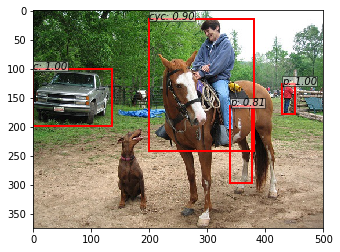

In [18]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

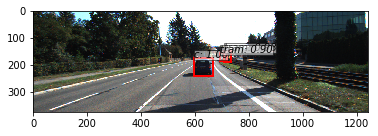

In [19]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict_mahalanobis(imgs,visualize=True)
vis_bbox(at.tonumpy(imgs[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

In [20]:
# VOC_BBOX_LABEL_NAMES = (
#     'car': blue,
#     'van': orange,
#     'truck': green,
#     'tram': red,
#     'person': purple,
#     'person_sitting': brown,
#     'cyclist': brown,
#     'misc': gray
#     # 'dontcare
# )